# NCAAM 2022 - XGB w/ FE on three Datasets

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns; sns.set()

YEAR = 2023
DATA_DIR = f'../../data/{YEAR}/MDataFiles'



## FE on RegularSeasonCompactResults

### Calculating Win %

In [2]:
compact_df = pd.read_csv(DATA_DIR + '/MRegularSeasonCompactResults.csv')

away_win = compact_df[compact_df.WLoc == 'A']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_A"})
neutral_win = compact_df[compact_df.WLoc == 'N']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_N"})
home_win = compact_df[compact_df.WLoc == 'H']\
    .groupby(['Season','WTeamID'])['WTeamID'].count().to_frame()\
    .rename(columns={"WTeamID": "win_H"})
win = away_win.join(neutral_win, how='outer').join(
    home_win, how='outer').fillna(0)

home_loss = compact_df[compact_df.WLoc == 'A']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_H"})
neutral_loss = compact_df[compact_df.WLoc == 'N']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_N"})
away_loss = compact_df[compact_df.WLoc == 'H']\
    .groupby(['Season','LTeamID'])['LTeamID'].count().to_frame()\
    .rename(columns={"LTeamID": "lost_A"})
lost = away_loss.join(neutral_loss, how='outer').join(
    home_loss, how='outer').fillna(0)

win.index = win.index.rename(['Season', 'TeamID'])
lost.index = lost.index.rename(['Season', 'TeamID'])
wl = win.join(lost, how='outer').reset_index()
wl['win_pct_A'] = wl['win_A'] / (wl['win_A'] + wl['lost_A'])
wl['win_pct_N'] = wl['win_N'] / (wl['win_N'] + wl['lost_N'])
wl['win_pct_H'] = wl['win_H'] / (wl['win_H'] + wl['lost_H'])
wl['win_pct_All'] = (wl['win_A'] + wl['win_N'] + wl['win_H']) / \
    (wl['win_A'] + wl['win_N'] + wl['win_H'] + wl['lost_A']\
     + wl['lost_N'] + wl['lost_H'])

del away_win, neutral_win, home_win, home_loss, neutral_loss, away_loss, win, lost


### Creating Score Features

In [3]:
compact_df['relScore'] = compact_df.WScore - compact_df.LScore

w_scr = compact_df.loc[:, ['Season', 'WTeamID', 'WScore', 'WLoc','relScore']]
w_scr.columns = ['Season', 'TeamID','Score','Loc','relScore']
l_scr = compact_df.loc[:, ['Season', 'LTeamID', 'LScore', 'WLoc','relScore']]
l_scr['WLoc'] = l_scr.WLoc.apply(lambda x: 'H' if x == 'A' else 'A' \
                                 if x == 'H' else 'N')
l_scr['relScore'] = -1 * l_scr.relScore 
l_scr.columns = ['Season', 'TeamID','Score','Loc','relScore']
wl_scr = pd.concat([w_scr,l_scr])

A_scr = wl_scr[wl_scr.Loc == 'A'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_A", "relScore": "relScore_A"})
N_scr = wl_scr[wl_scr.Loc == 'N'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_N", "relScore": "relScore_N"})
H_scr = wl_scr[wl_scr.Loc == 'H'].groupby(['Season','TeamID'])\
        ['Score','relScore'].mean()\
        .rename(columns={"Score": "Score_H", "relScore": "relScore_H"})
All_scr = wl_scr.groupby(['Season','TeamID'])['Score','relScore']\
    .mean().rename(columns={"Score": "Score_All", "relScore": "relScore_All"})
scr = A_scr.join(N_scr, how='outer').join(H_scr, how='outer')\
    .join(All_scr, how='outer').fillna(0).reset_index()

del w_scr, l_scr, wl_scr, A_scr, H_scr, N_scr, All_scr

C:\Users\conor\AppData\Local\Temp\ipykernel_35336\88771312.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  A_scr = wl_scr[wl_scr.Loc == 'A'].groupby(['Season','TeamID'])\
C:\Users\conor\AppData\Local\Temp\ipykernel_35336\88771312.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  N_scr = wl_scr[wl_scr.Loc == 'N'].groupby(['Season','TeamID'])\
C:\Users\conor\AppData\Local\Temp\ipykernel_35336\88771312.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  H_scr = wl_scr[wl_scr.Loc == 'H'].groupby(['Season','TeamID'])\
C:\Users\conor\AppData\Local\Temp\ipykernel_35336\88771312.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  All_scr = wl_scr.groupby(['Season','

## FE on MRegularSeasonDetailedResults

In [4]:
dt = pd.read_csv(DATA_DIR + '/MRegularSeasonDetailedResults.csv')

winning_detailed = dt.loc[:, ['Season', 'WTeamID', 'WFGM', 'WFGA', 'WFGM3'                               ,'WFGA3','WFTM','WFTA','WOR','WDR','WAst',
                               'WTO','WStl','WBlk','WPF']]
winning_detailed.columns = ['Season', 'TeamID', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR',
             'Ast','TO','Stl','Blk','PF']
losing_detailed = dt.loc[:, ['Season', 'LTeamID', 'LFGM', 'LFGA', 'LFGM3',
                               'LFGA3','LFTM','LFTA','LOR','LDR','LAst',
                               'LTO','LStl','LBlk','LPF']]
losing_detailed.columns = ['Season', 'TeamID', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR',
             'Ast','TO','Stl','Blk','PF']

detailed = pd.concat([winning_detailed, losing_detailed])
detailed['goal_rate'] = detailed.FGM / detailed.FGA
detailed['3p_goal_rate'] = detailed.FGM3 / detailed.FGA3
detailed['ft_goal_rate'] = detailed.FTM / detailed.FTA

detailed_df = detailed.groupby(['Season', 'TeamID'])['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
                                         'OR','DR','Ast','TO','Stl','Blk','PF',
                                          'goal_rate', '3p_goal_rate',
                                         'ft_goal_rate']\
                                        .mean().fillna(0).reset_index()

del winning_detailed, losing_detailed, detailed


C:\Users\conor\AppData\Local\Temp\ipykernel_35336\2665603748.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  detailed_df = detailed.groupby(['Season', 'TeamID'])['FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',


## FE on MMasseyOrdinals

Using only MOR for now.

In [5]:
MMOrdinals = pd.read_csv(DATA_DIR + '/MMasseyOrdinals.csv')

MOR_127_128 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 127) \
                 | (MMOrdinals.RankingDayNum == 128))]\
                [['Season','TeamID','OrdinalRank']]
MOR_50_51 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 50) \
                 | (MMOrdinals.RankingDayNum == 51))]\
                [['Season','TeamID','OrdinalRank']]
MOR_15_16 = MMOrdinals[(MMOrdinals.SystemName == 'MOR') & \
                ((MMOrdinals.RankingDayNum == 15) \
                 | (MMOrdinals.RankingDayNum == 16))]\
                [['Season','TeamID','OrdinalRank']]

MOR_127_128 = MOR_127_128.rename(columns={'OrdinalRank':'OrdinalRank_127_128'})
MOR_50_51 = MOR_50_51.rename(columns={'OrdinalRank':'OrdinalRank_50_51'})
MOR_15_16 = MOR_15_16.rename(columns={'OrdinalRank':'OrdinalRank_15_16'})

MOR = MOR_127_128.merge(MOR_50_51, how='left', on=['Season','TeamID'])\
        .merge(MOR_15_16, how='left', on=['Season','TeamID'])

## normalizing Rank values by its season maxium as it varies by seasons
MOR_max = MOR.groupby('Season')['OrdinalRank_127_128','OrdinalRank_50_51',
                                'OrdinalRank_15_16'].max().reset_index()
MOR_max.columns = ['Season', 'maxRank_127_128', 'maxRank_50_51', 'maxRank_15_16']

MOR_tmp = MMOrdinals[(MMOrdinals.SystemName == 'MOR') \
                     & (MMOrdinals.RankingDayNum < 133)]
MOR_stats = MOR_tmp.groupby(['Season','TeamID'])['OrdinalRank']\
            .agg(['max','min','std','mean']).reset_index()
MOR_stats.columns = ['Season','TeamID','RankMax','RankMin','RankStd','RankMean']

MOR = MOR.merge(MOR_max, how='left', on='Season')\
        .merge(MOR_stats, how='left', on=['Season','TeamID'])
MOR['OrdinalRank_127_128'] = MOR['OrdinalRank_127_128'] / MOR['maxRank_127_128']
MOR['OrdinalRank_50_51'] = MOR['OrdinalRank_50_51'] / MOR['maxRank_50_51']
MOR['OrdinalRank_15_16'] = MOR['OrdinalRank_15_16'] / MOR['maxRank_15_16']
MOR['RankTrans_50_51_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_50_51']
MOR['RankTrans_15_16_to_127_128'] = MOR['OrdinalRank_127_128'] \
                                    - MOR['OrdinalRank_15_16']

MOR['RankMax'] = MOR['RankMax'] / MOR['maxRank_127_128']
MOR['RankMin'] = MOR['RankMin'] / MOR['maxRank_127_128']
MOR['RankStd'] = MOR['RankStd'] / MOR['maxRank_127_128']
MOR['RankMean'] = MOR['RankMean'] / MOR['maxRank_127_128']

MOR.drop(['OrdinalRank_50_51','OrdinalRank_15_16', 'maxRank_50_51'
          ,'maxRank_15_16'],axis=1, inplace=True)

del MOR_127_128, MOR_50_51, MOR_15_16, MOR_max, MOR_tmp, MOR_stats

C:\Users\conor\AppData\Local\Temp\ipykernel_35336\738975703.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MOR_max = MOR.groupby('Season')['OrdinalRank_127_128','OrdinalRank_50_51',


Duplicating each data with changing column names to be matched to 'WTeamID' and 'LTeamID' in Tourney dataset

In [6]:
wl_dupe1 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_dupe1.columns = [str(col) + '_1' if col not in ['Season', 'TeamID']
                    else str(col) for col in wl_dupe1.columns]

wl_dupe2 = wl.loc[:,['Season','TeamID','win_pct_A','win_pct_N',
                 'win_pct_H','win_pct_All']]
wl_dupe2.columns = [str(col) + '_2' if col not in ['Season', 'TeamID']
                    else str(col) for col in wl_dupe2.columns]

scr_1 = scr.copy()
scr_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_1.columns ]

scr_2 = scr.copy()
scr_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in scr_2.columns ]

dt_1 = detailed_df.copy()
dt_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_1.columns ]

dt_2 = detailed_df.copy()
dt_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                else str(col) for col in dt_2.columns ]

MOR_1 = MOR.copy()
MOR_1.columns = [str(col) + '_1' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_1.columns ]

MOR_2 = MOR.copy()
MOR_2.columns = [str(col) + '_2' if col not in ['Season','TeamID'] \
                 else str(col) for col in MOR_2.columns ]

## Loading MNCAATourneyCompactResults

This dataset will be the base dataset for the model training

In [7]:
TCResults = pd.read_csv(DATA_DIR + '/MNCAATourneyCompactResults.csv')

tourney1 = TCResults.loc[:, ['Season','WTeamID','LTeamID']]
tourney1.columns = ['Season','TeamID1','TeamID2']
tourney1['result'] = 1

tourney2 = TCResults.loc[:, ['Season','LTeamID','WTeamID']]
tourney2.columns = ['Season','TeamID1','TeamID2']
tourney2['result'] = 0

tourney = pd.concat([tourney1, tourney2])
del tourney1, tourney2

### Merging engineered features to Tourney dataset

In [8]:
def merge_data(df):

    df = df.merge(wl_dupe1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(wl_dupe2, how='left', left_on=['Season', 'TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)


    df = df.merge(scr_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(scr_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df['win_pct_A_diff'] = df['win_pct_A_1'] - df['win_pct_A_2']
    df['win_pct_N_diff'] = df['win_pct_N_1'] - df['win_pct_N_2']
    df['win_pct_H_diff'] = df['win_pct_H_1'] - df['win_pct_H_2']
    df['win_pct_All_diff'] = df['win_pct_All_1'] - df['win_pct_All_2']

    df['Score_A_diff'] = df['Score_A_1'] - df['Score_A_2']
    df['Score_N_diff'] = df['Score_N_1'] - df['Score_N_2']
    df['Score_H_diff'] = df['Score_H_1'] - df['Score_H_2']
    df['Score_All_diff'] = df['Score_All_1'] - df['Score_All_2']

    df['relScore_A_diff'] = df['relScore_A_1'] - df['relScore_A_2']
    df['relScore_N_diff'] = df['relScore_N_1'] - df['relScore_N_2']
    df['relScore_H_diff'] = df['relScore_H_1'] - df['relScore_H_2']
    df['relScore_All_diff'] = df['relScore_All_1'] - df['relScore_All_2']

    df = df.merge(dt_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(dt_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df = df.merge(MOR_1, how='left', left_on=['Season','TeamID1'],
                  right_on=['Season','TeamID'])
    df = df.merge(MOR_2, how='left', left_on=['Season','TeamID2'],
                  right_on=['Season','TeamID'])
    df = df.drop(['TeamID_x','TeamID_y'], axis=1)

    df['OrdinalRank_127_128_diff'] = df['OrdinalRank_127_128_1'] \
        - df['OrdinalRank_127_128_2']
    
    df['magic1'] = df['OrdinalRank_127_128_diff'] - df['RankMean_1']
    df['magic2'] = df['RankMean_1'] - df['RankMean_2']
    df['magic3'] = df['OrdinalRank_127_128_diff'] - df['RankMean_2']
    
    df['magic11'] = df['OrdinalRank_127_128_diff'] * df['RankMean_1']
    df['magic21'] = df['RankMean_1'] * df['RankMean_2']
    df['magic31'] = df['OrdinalRank_127_128_diff'] * df['RankMean_2']
    
    df['magic12'] = df['OrdinalRank_127_128_diff'] / df['RankMean_1']
    df['magic22'] = df['RankMean_1'] / df['RankMean_2']
    df['magic32'] = df['OrdinalRank_127_128_diff'] / df['RankMean_2']

    df = df.fillna(-1)
    
    for col in df.columns:
        if (df[col] == np.inf).any() or (df[col] == -np.inf).any():
            df[col][(df[col] == np.inf) | (df[col] == -np.inf)] = -1
    
    return df

tourney = merge_data(tourney)
tourney = tourney.loc[tourney.Season >= 2003,:].reset_index(drop=True)

## Loading Submission Dataset
Duplicating each ID with swapping TeamIDs. Predictions will be averaged by ID to get better performance.

In [9]:
MSampleSubmission = pd.read_csv(DATA_DIR + '/MSampleSubmissionStage1.csv')

test1 = MSampleSubmission.copy()
test1['Season'] = test1.ID.apply(lambda x: int(x[0:4]))
test1['TeamID1'] = test1.ID.apply(lambda x: int(x[5:9]))
test1['TeamID2'] = test1.ID.apply(lambda x: int(x[10:14]))

test2 = MSampleSubmission.copy()
test2['Season'] = test2.ID.apply(lambda x: int(x[0:4]))
test2['TeamID1'] = test2.ID.apply(lambda x: int(x[10:14]))
test2['TeamID2'] = test2.ID.apply(lambda x: int(x[5:9]))

test = pd.concat([test1,test2]).drop(['Pred'], axis=1)
test = merge_data(test)

## Model Training

In [10]:
X = tourney.drop(['Season','TeamID1','TeamID2','result'], axis=1)
y = tourney["result"]
s = tourney["Season"]

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

In [11]:
from sklearn.svm import SVC
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm

train = tourney
test = test

xgb_params= {
        "objective": "binary:logistic",
        "max_depth": 2,
        "learning_rate": 0.1,
        "colsample_bytree": 0.8,
        "subsample": 0.8,
        "min_child_weight": 30,
        "n_jobs": 2,
        "seed": 2021,
        "tree_method": "hist",
        'predictor': 'cpu_predictor'
    }

y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)

X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

train_oof = np.zeros((X.shape[0],))
test_preds = 0
train_oof.shape

NUM_FOLDS = 10
kf = GroupKFold(n_splits=NUM_FOLDS)
max_iter = 550

for f, (train_ind, val_ind) in enumerate(kf.split(X, y, s)):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind], X.iloc[val_ind]
        train_target, val_target = y.iloc[train_ind], y.iloc[val_ind]
        train_df_xgb = xgb.DMatrix(train_df, label=train_target)
        val_df_xgb = xgb.DMatrix(val_df, label=val_target)
        
        model = HistGradientBoostingClassifier(max_iter=max_iter, validation_fraction=None, learning_rate=0.01, max_depth=2, min_samples_leaf=32)
        model1 = RandomForestClassifier()
        model2 = LogisticRegression(C=1)
        model3 = SVC(probability=True)
        model4 = xgb.train(xgb_params, train_df_xgb, 1000)

        model =  model.fit(train_df, train_target)
        model1 =  model1.fit(train_df, train_target)
        model2 =  model2.fit(train_df, train_target)
        model3 =  model3.fit(train_df, train_target)

        temp_oof = model2.predict_proba(val_df)[:,1]
        temp_test = model2.predict_proba(X_test)[:,1]
        
        temp_oof = (model.predict_proba(val_df)[:,1] + \
                    model1.predict_proba(val_df)[:,1] + \
                    model2.predict_proba(val_df)[:,1] + \
                    model3.predict_proba(val_df)[:,1] + \
                    model4.predict(val_df_xgb)) / 4
        temp_test = (model.predict_proba(X_test)[:,1] \
                     + model1.predict_proba(X_test)[:,1] \
                     + model2.predict_proba(X_test)[:,1] \
                     + model3.predict_proba(X_test)[:,1] \
                     + model4.predict(xgb.DMatrix(X_test))) / 4

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        print(log_loss(val_target, temp_oof))
        
print('CV', log_loss(y, train_oof))        
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)

test = test
MSampleSubmission = pd.read_csv(f'{DATA_DIR}/MSampleSubmissionStage1.csv')

idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub3 = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
pred_3 = sub3['Pred']


1.9358115084387533
0.8164243740059335
1.0114054337623013
0.8009717553813466
0.9661517682496332
0.8988335570044312
0.9605748809951038
0.5844800946719618
1.2378796111749795
0.4872974425510156
CV 0.9962839523481231


## Creating Submission File

The second half of the test prediction need to be (1 - pred) as the team order was swapped. The predictions are averaged by ID after that.

In [12]:
idx = test_preds.shape[0] //2
test_preds[idx:] = 1 - test_preds[idx:]

pred = pd.concat([test.ID, pd.Series(test_preds)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub['Pred'] = sub['Pred'] * 0.3 + sub3['Pred'] * 0.7
sub.to_csv('submission.csv', index=False)
sub.head()

,ID,Pred
0,2023_1101_1102,0.485001
1,2023_1101_1103,0.334925
2,2023_1101_1104,0.158884
3,2023_1101_1105,0.681359
4,2023_1101_1106,0.742455


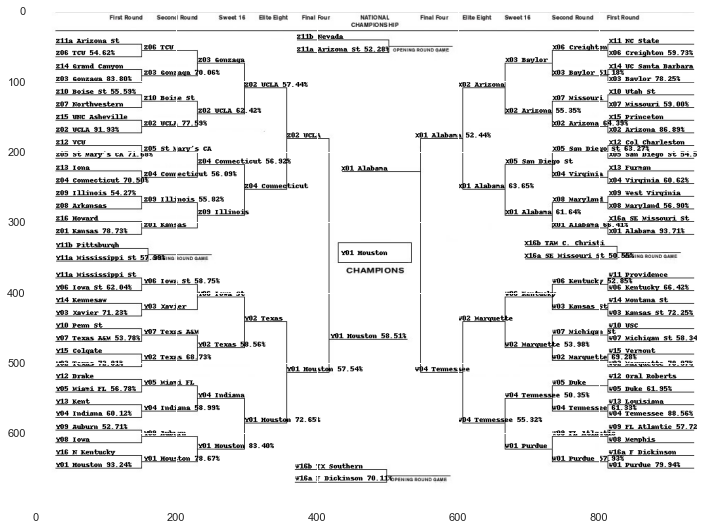

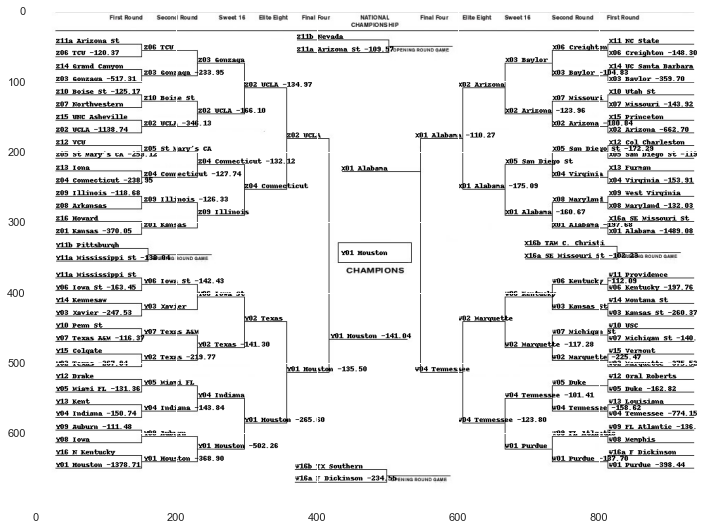

In [13]:
import sys
import os
folder_name = "march_madness"
BASE_DIR = os.path.abspath(".").split(folder_name)[0]+folder_name
#DATA_ROOT = os.path.join(BASE_DIR, "data")
sys.path.insert(0, BASE_DIR)

from generate_bracket import build_bracket

b = build_bracket(
    teamsPath=f"{DATA_DIR}/MTeams.csv",
    seedsPath=f"{DATA_DIR}/MNCAATourneySeeds.csv",
    slotsPath=f"{DATA_DIR}/MNCAATourneySlots.csv",
    submissionPath="submission.csv",
    emptyBracketPath="../../empty_bracket/empty.jpg",
    year=int(YEAR)
)

b = build_bracket(
    teamsPath=f"{DATA_DIR}/MTeams.csv",
    seedsPath=f"{DATA_DIR}/MNCAATourneySeeds.csv",
    slotsPath=f"{DATA_DIR}/MNCAATourneySlots.csv",
    submissionPath="submission.csv",
    emptyBracketPath="../../empty_bracket/empty.jpg",
    year=int(YEAR),
    spread=True
)


## Calculating Test Score Locally

In [14]:
if STAGE_1:
    rslt = pd.DataFrame()
    TCResults_s = TCResults.loc[TCResults.Season >= 2015, :]
    rslt['season'] = TCResults_s.Season
    rslt['team1'] = TCResults_s.apply(lambda x: x.WTeamID
                                      if x.WTeamID < x.LTeamID else x.LTeamID, axis=1)
    rslt['team2'] = TCResults_s.apply(lambda x: x.WTeamID
                                      if x.WTeamID > x.LTeamID else x.LTeamID, axis=1)
    rslt['wl'] = TCResults_s.apply(
        lambda x: 1 if x.WTeamID < x.LTeamID else 0, axis=1)
    rslt['ID'] = rslt.apply(lambda x: str(x.season) + '_' + str(x.team1)
                            + '_' + str(x.team2), axis=1)
    sub2 = sub.merge(rslt.loc[:, ['ID', 'wl']], how='inner', on='ID')

    preds = []
    for i in sub2.Pred:
        preds.append([1-i, i])

    print('Test logloss is {:.5f}'.format(log_loss(sub2.wl.values, preds)))
